<a href="https://colab.research.google.com/github/PashaIanko/RestrictedBolzmannMachine/blob/main/Omniglot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper links:
- https://github.com/pytorch/vision/blob/main/torchvision/datasets/omniglot.py

## **Packages, Constants & Functions**

In [10]:
# Preprocessing
CROP_SIZE_ = 90
MEAN_ = 0.5
STD_ = 0.5
IMG_SIZE_ = CROP_SIZE_

# Train
EPOCHS_ = 300
BATCH_SIZE_ = 80
LABEL_FROM_ = 0
LABEL_TO_ = 28
LABEL_MIN_ = 0
LABEL_MAX_ = 963

# Alphabets
# key - alphabet, value - start and finish labels
ALPHABETS_DICT_ = {
    'First': [0, 25]  # Label limits
}

In [2]:
%%capture

url_dbn = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm
}

for file, url in utils.items():
    !wget -O {file} {url} {file}

In [3]:
import torch
import torchvision as tv
from torchvision import datasets

# Models
from DBN import DBN

# Plotting
import matplotlib.pyplot as plt

# Download
from google.colab import drive
from os import path

# Utils
import numpy as np
import random
import math

In [4]:
def fix_seeds():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [5]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img, _ = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

In [6]:
def find_image(ds, label):
    for item in ds:
        if item[1] == label:
            return item[0]

def visualize_letters(labels, image_shape, ds):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )

    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        label = labels[i]
        
        image = find_image(ds, label)
        axes[row, col].imshow(torch.flatten(image).reshape(image_shape), cmap='binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels

In [59]:
def move_parameters_to_cpu(dbn_mnist):
    for layer in dbn_mnist.rbm_layers:
        layer.W = layer.W.cpu()
        layer.h_bias = layer.h_bias.cpu()
        layer.v_bias = layer.v_bias.cpu()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights_matrices, num_subplots = 64, 
                                img_width=IMG_SIZE_, img_height=IMG_SIZE_, 
                                fig_size = (20, 20)):
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=fig_size)
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        
        # Matrix of connection strength (W) of i-th unit of the layer.
        # Reshape from 'linear' to 'image' representation
        W_matrix = weights_matrices[i, :].reshape((img_width, img_height))
        axes[row, col].imshow(W_matrix, cmap = plt.cm.gray)

## **Data Download**

- For neural networks, we need to scale data before learning
- Need to obtain tensor shape
- Fix seeds for reproducibility

In [8]:
%%capture 

fix_seeds()

transformer = tv.transforms.Compose(
    [
        tv.transforms.CenterCrop(CROP_SIZE_),
        tv.transforms.ToTensor(),
        
        # Transform to {-1, 1} binary image
        tv.transforms.Normalize(mean=(MEAN_,), std=(STD_),)  
    ]
)

train = datasets.Omniglot(
    root = '/content/',
    download = True,
    background = True,
    transform = transformer
)

test = datasets.Omniglot(
    root = '/content/',
    download = True,
    background = False,
    transform = transformer
)

Image shape = torch.Size([1, 90, 90])


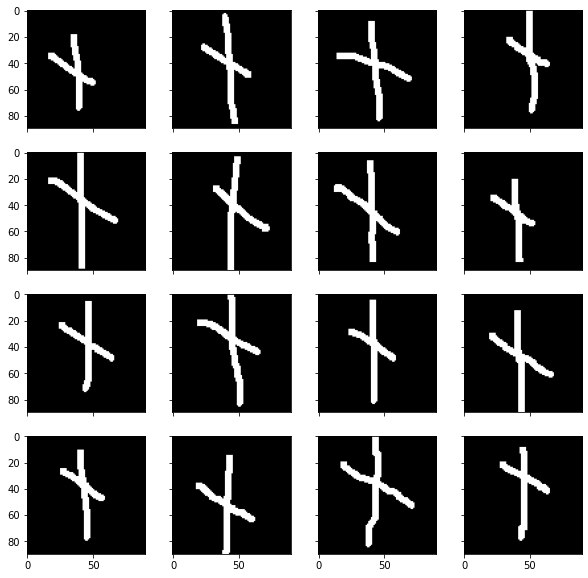

In [9]:
img, _ = train[0]
print(f'Image shape = {img.shape}')
visualize_symbols(train, 16, image_shape = (CROP_SIZE_, CROP_SIZE_))

In [ ]:
# __getitem__ structure - tensor (image) + label (one label for 20 images of single letter)
train.__getitem__(19)

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]), 0)

## **Visualize Data (alphabets)**

- 1st conclusion:  
    - 1 Dataset
    - 50 Alphabets
    - 20-30 characters in each (varies)
    - 20 images for one character
    - First 20 images (from 0 to 19) are labeled '0' (first character),
        then next character is labeled '1' and so on
    - 964 unique labels


In [ ]:
print(f'Available alphabets:')
for alph in train._alphabets: print(alph)

Available alphabets:
Anglo-Saxon_Futhorc
Arcadian
Bengali
Burmese_(Myanmar)
Ojibwe_(Canadian_Aboriginal_Syllabics)
Asomtavruli_(Georgian)
Hebrew
Early_Aramaic
Braille
Tagalog
Japanese_(katakana)
Gujarati
Greek
Syriac_(Estrangelo)
Alphabet_of_the_Magi
Futurama
Armenian
Blackfoot_(Canadian_Aboriginal_Syllabics)
N_Ko
Malay_(Jawi_-_Arabic)
Balinese
Tifinagh
Mkhedruli_(Georgian)
Japanese_(hiragana)
Grantha
Latin
Korean
Cyrillic
Inuktitut_(Canadian_Aboriginal_Syllabics)
Sanskrit


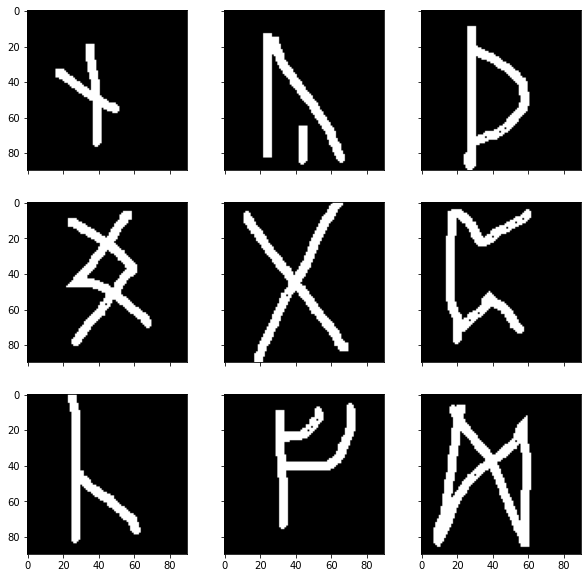

In [ ]:
# Visualize first few letters of one alphabet
visualize_letters(
    labels = [0, 1, 2,
              3, 4, 5,
              6, 7, 8
              ],
    
    image_shape = (IMG_SIZE_, IMG_SIZE_),
    ds = train
)

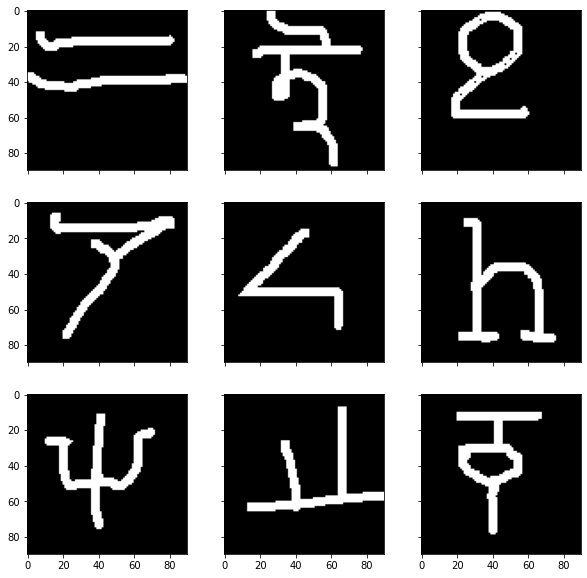

In [ ]:
# Visualize letters of different alphabets 
visualize_letters(
    labels = [
              0, 30, 60,
              90, 120, 150,
              180, 210, 240
              ],
    image_shape = (IMG_SIZE_, IMG_SIZE_),
    ds = train
)

## **Prepare Data (Select alphabets & labels)**

- First alphabet - labels from [0, 25]

In [ ]:
# all_labels = [item[1] for item in train]
# all_images = [item[0] for item in train]

In [11]:
# Slice and choose only subset of certain alphabet labels
images, labels = prepare_data(
    train, 
    label_from = LABEL_FROM_,  
    label_to = LABEL_TO_
)
print(f'Size of the dataset = {len(labels)}')

Size of the dataset = 580


In [12]:
# To Tensors
labels = torch.FloatTensor(labels)
buffer = torch.Tensor(len(images), IMG_SIZE_, IMG_SIZE_)
torch.cat(images, out=buffer)
images = buffer

In [13]:
print(type(labels), type(images))
print(type(labels[0]), type(images[0]))

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


## **Deep Belief Network model & fit**

- Deep Belief Network - a stack of Restricted Bolzmann Machines
    - RBM is a bipartite graph with input and hidden layer
    - Hidden layer captures dependencies and features
- Each layer learns more complex and abstract features
- Used as feature extraction method (generative model)
- No output neurons
- Two phases (negative & positive) during learning (reconstruction)




In [14]:
fix_seeds()

model = DBN(
    visible_units = IMG_SIZE_ * IMG_SIZE_,
    hidden_units = [500, 500, 1200],  # [500, 500, 1200],
    k = 1,
    learning_rate = 0.07,
    learning_rate_decay = False,
    initial_momentum = 0.5,
    final_momentum = 0.9,
    weight_decay = 0.00002,
    xavier_init = False,
    increase_to_cd_k = False,
    use_gpu = True
)

In [15]:
fix_seeds()

model.train_static(
    images,
    labels,
    EPOCHS_,
    BATCH_SIZE_
)

move_parameters_to_cpu(model)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |37.2006   |3.7496   |26065.5371 |1531.8673   |
|20    |37.5611   |3.8998   |25409.6406 |1514.7329   |
|30    |37.5573   |3.8366   |25237.0312 |1818.5856   |
|40    |37.5507   |3.7783   |25159.6348 |1668.6813   |
|50    |37.6269   |3.7097   |25403.0000 |1706.9845   |
|60    |37.6557   |3.7593   |25418.4395 |1867.5178   |
|70    |37.6974   |3.8580   |25730.3027 |1954.7913   |
|80    |37.6919   |3.8478   |25677.9238 |1896.7965   |
|90    |37.6750   |3.8775   |25735.2773 |1729.8708   |
|100    |37.6625   |3.8365   |25637.7559 |1848.2111   |
|110    |37.6997   |3.8185   |25577.0605 |1965.1356   |
|120    |37.6872   |3.7525   |25346.4004 |1911.5563   |
|130    |37.6698   |3.8276   |25317.9746 |2078.7441   |
|140    |37.6271   |3.9281   |25080.8164 |1704.2916   |
|150    |37.6470   |3.8701   |25337.4277 |1901.2341   |
|160    |37.6372   |3.9033   |25192.9102 |1981.7136   |
|170    |37.6

## **Linear read-outs. Receptive fields visualization**

Lets understand the structure of network & layers
- Input layer size - (IMG_SIZE_ * IMG_SIZE_)
- 0-level of RBM network with N units -> has connection matrix W. 
Size of W = N_units * (IMG_SIZE_ * IMG_SIZE_)
- We can consider W matrix of 0-level as N "images" of size (IMG_SIZE_ * IMG_SIZE_)
- Hence, we can visualize connection strengths, starting from 0 hidden level

In [28]:
print(type(model.rbm_layers[0].W))
print(type(model.rbm_layers[0].W.numpy()))
print(model.rbm_layers[0].W.size())
print(model.rbm_layers[1].W.size())

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([8100, 500])
torch.Size([500, 500])


In [36]:
# Converting and processing W matrices of hidden layers
# We transpose for convenience (matrices[i, :] is more intuitive than matrices[:, i])

num_layers = len(model.rbm_layers)

learned_weights = [
    model.rbm_layers[i].W.transpose(0, 1).numpy() for i in range(num_layers)
]

learned_weights_thresh = [apply_threshold(weights_matrix, .08) for weights_matrix in learned_weights]

in func


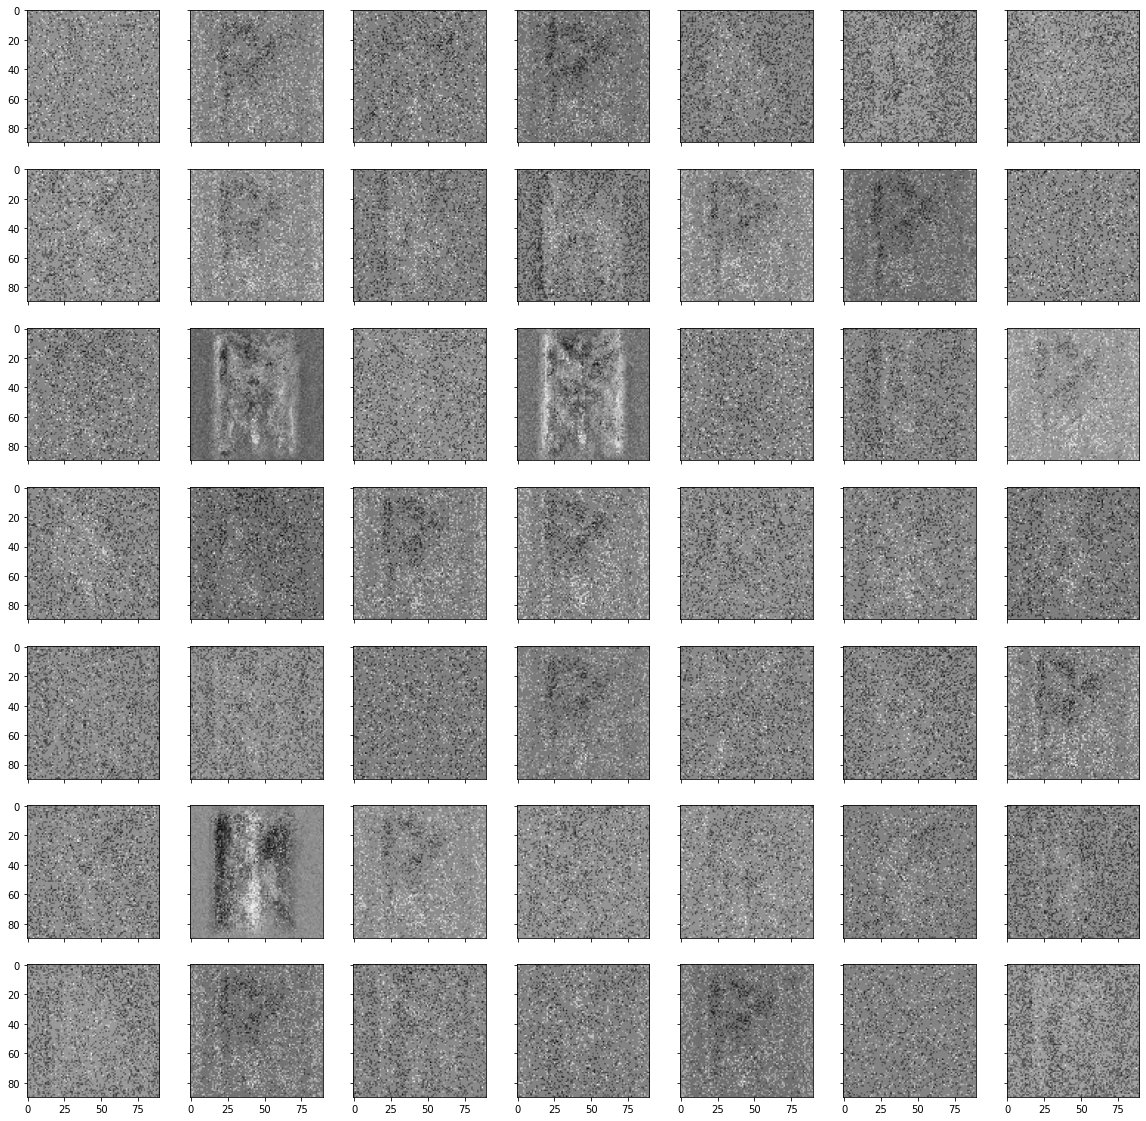

In [58]:
plot_layer_receptive_fields(learned_weights_thresh[0], num_subplots=49)

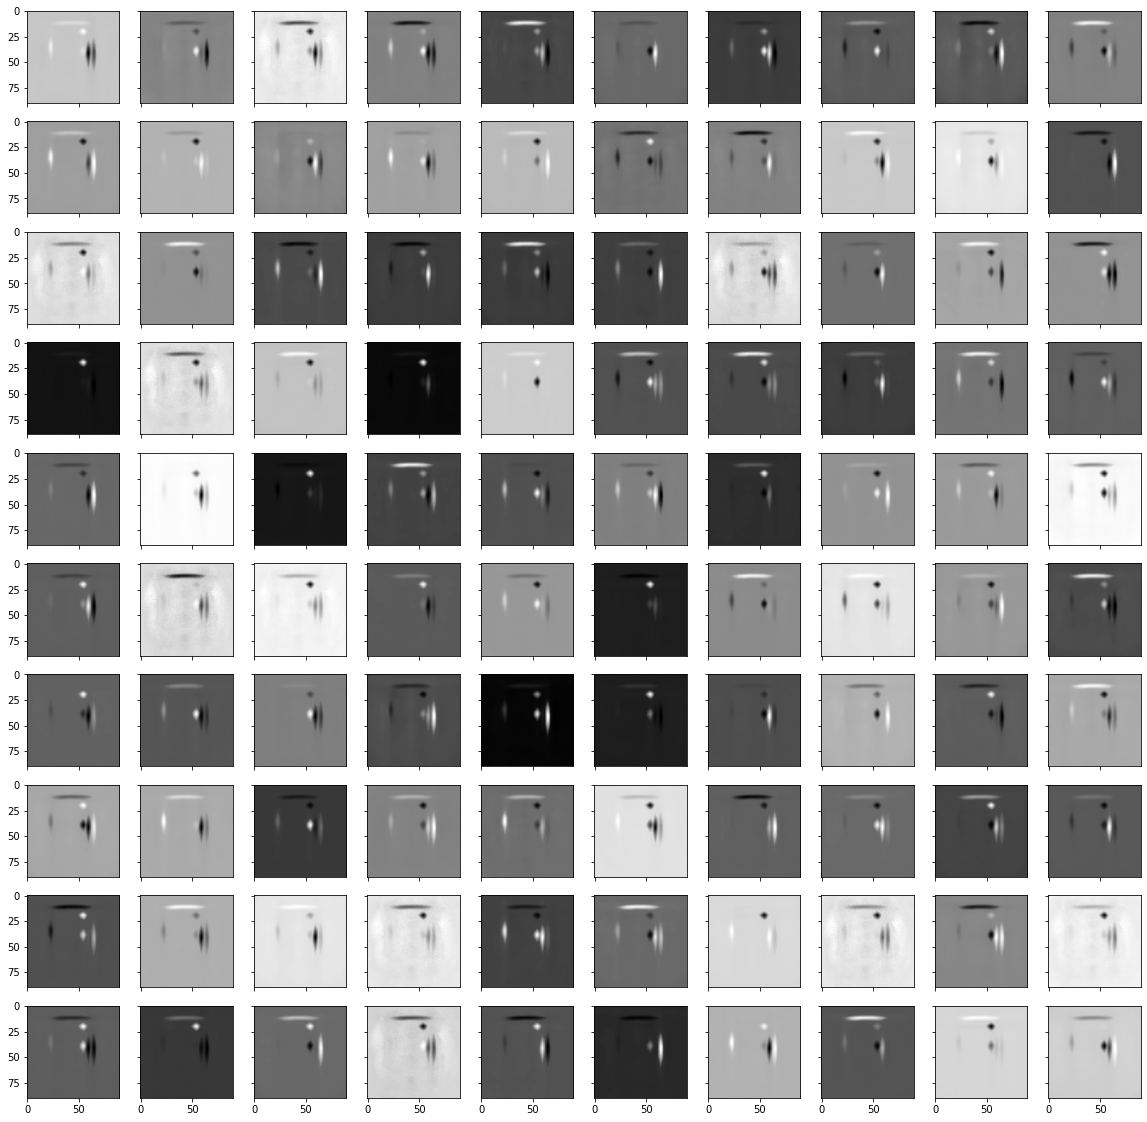

In [ ]:
weight_product = (learned_weights[0] @ learned_weights[1]).T
plot_layer_receptive_fields(
    apply_threshold(weight_product), num_subplots = 100
)

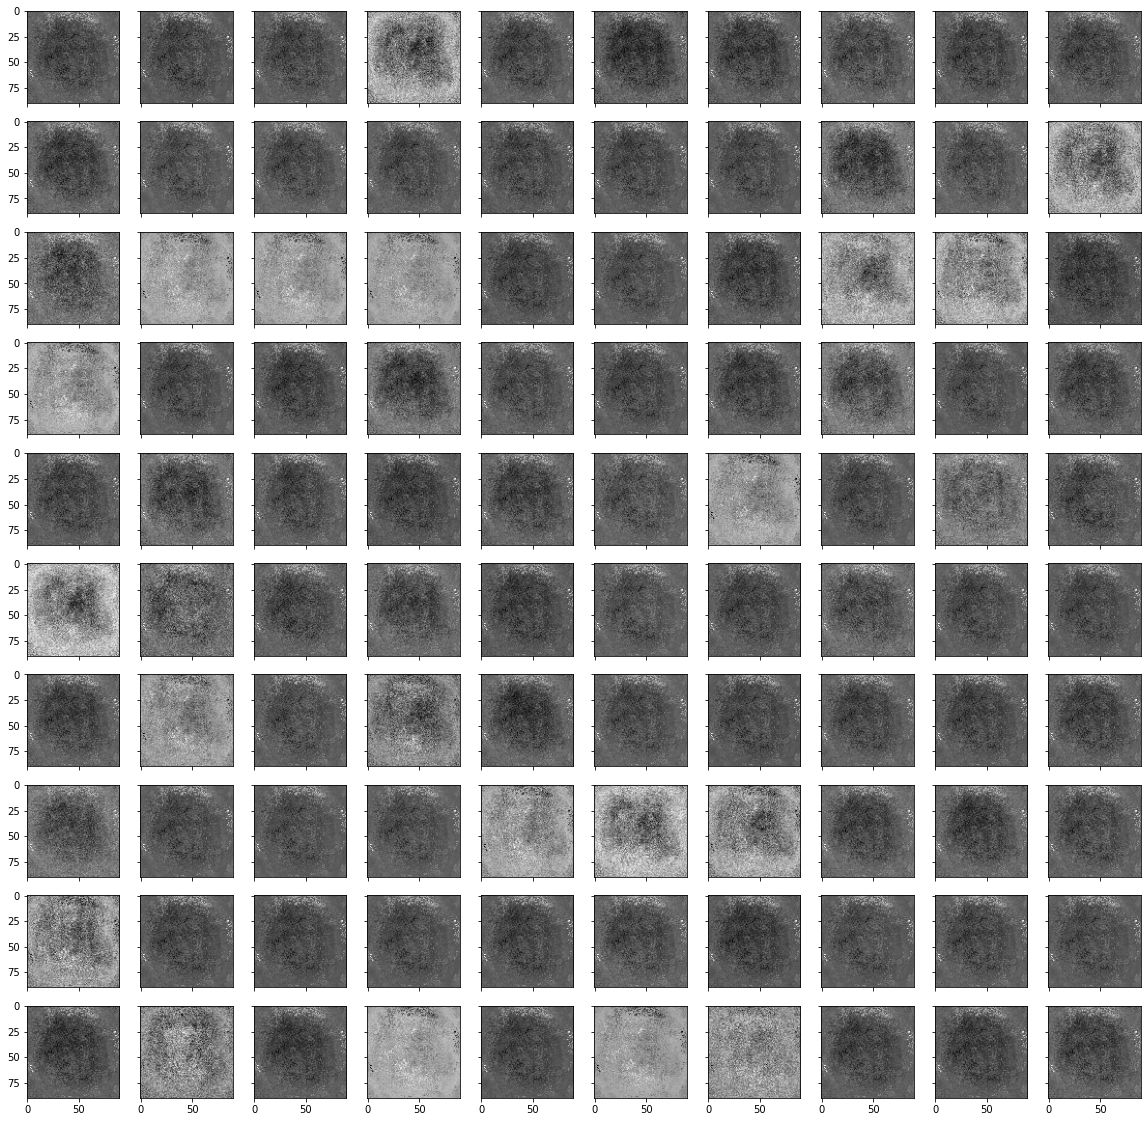

In [ ]:
learned_weights_layer_1 = model.rbm_layers[0].W.numpy()
learned_weights_layer_2 = model.rbm_layers[1].W.numpy()

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0)

plot_layer_receptive_fields(learned_weights_product)